In [1]:
import numpy as np
import matplotlib.pyplot as plt
from traj_opt import TrajOpt
from scipy.optimize import minimize, Bounds, NonlinearConstraint

import matplotlib.animation as animation
import matplotlib.patches as mpatches
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

blue = np.array([0.12156862745098,0.466666666666667,0.705882352941177])
red = [0.83921568627451,0.152941176470588,0.156862745098039]

In [2]:
ndof = 2

filename = "animation_time_opt"
fps = 30
lw_ = 3
fw_ = 16
fh_ = 4
fontsize_ = 24

In [3]:
to = TrajOpt(ndof)

## N via points at random positions

In [4]:
y_nodes = np.array([[0,0], [0.0,0.3], [1.0,0.7], [1,1]])
#y_nodes = np.array([[0,0], [0.0,0.15], [0.85,1.0], [1,1]])
#y_nodes = np.array([[0,0], [0.0,0.15], [1.0,0.85], [1,1]])
dy_0 = np.zeros(2)
dy_T = np.zeros(2)
N = len(y_nodes)-1

# N = 10

# y_nodes = np.zeros((N+1, ndof))
# for n in range(N+1):
#     y_nodes[n] = np.random.uniform(-1, 1, 2)
# dy_0 = np.zeros(2)
# dy_T = np.zeros(2)

In [5]:
dy_lim = 1.0
ddy_lim = 2.0

In [6]:
def get_dy(h):
    dt = 2e-2
    T = np.sum(h)
    to.setup_task(h)
    return to.get_dy(np.linspace(0,T,int(T/dt)+1), y_nodes, dy_0, dy_T).flatten()

def get_dy_max(h):
    to.setup_task(h)
    t_max = np.zeros(N*ndof)
    w = np.concatenate((y_nodes.flatten(), dy_0, dy_T))
    for n in range(N):
        Omega = to.get_Omega(n)
        for d in range(ndof):
            w_d = w[d::ndof]
            alpha = Omega @ w_d
            t_max[n*ndof+d] = np.clip(np.sum(h[:n]) + alpha[1] / alpha[0], np.sum(h[:n]), np.sum(h[:n+1]))
    
    return to.get_dy(t_max, y_nodes, dy_0, dy_T).flatten()

In [7]:
def get_ddy(h):
    dt = 2e-2
    T = np.sum(h)
    print(T,int(T/dt)+1)
    to.setup_task(h)
    return to.get_ddy(np.linspace(0,T,100), y_nodes, dy_0, dy_T).flatten()

def get_ddy_max(h):
    to.setup_task(h)
    t_nodes = np.zeros(N+1)
    for n in range(N):
        t_nodes[n+1] = np.sum(h[:n+1])
    
    return to.get_ddy(t_nodes, y_nodes, dy_0, dy_T).flatten()

In [8]:
alpha = 0.1

def time_cost(h):
    print(h)
    return alpha*np.sum(h)
def time_grad(h):
    return alpha*np.ones(len(h))

bound = Bounds(1e-3*np.ones(N), 20.*np.ones(N))

nlc_dy = NonlinearConstraint(get_dy_max, -dy_lim, dy_lim)
nlc_ddy = NonlinearConstraint(get_ddy_max, -ddy_lim, ddy_lim)

# import time
# start = time.time()

# res = minimize(time_cost, 0.1*np.ones(N), jac=time_grad, method='SLSQP', bounds=bound, constraints=[nlc_dy, nlc_ddy], options={'maxiter': 1, 'ftol': 1e-6, 'disp': True})

# print("Elapsed time: ",time.time()-start," [s]")

# print(res.x, time_cost(res.x), get_dy_max(res.x), get_ddy_max(res.x))

def get_optimal_h(iter):
    res = minimize(time_cost, 0.1*np.ones(N), jac=time_grad, method='SLSQP', bounds=bound, constraints=[nlc_dy, nlc_ddy], options={'maxiter': iter, 'ftol': 1e-6, 'disp': True})
    return res.x

In [9]:
iteration = 13

h_list = []
for i in range(iteration):
    h_list.append(get_optimal_h(i))

#h_array = np.zeros(iteration*25)

T_res = np.sum(h_list[-1])
fps = 30
res = 200

[0.1 0.1 0.1]
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.030000000000000006
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
[0.1 0.1 0.1]
[0.1462236 0.1522137 0.1462236]
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.04446609123486226
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
[0.1 0.1 0.1]
[0.1462236 0.1522137 0.1462236]
[0.21194111 0.23357947 0.21194111]
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.06574616886989108
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
[0.1 0.1 0.1]
[0.1462236 0.1522137 0.1462236]
[0.21194111 0.23357947 0.21194111]
[0.30292525 0.36410309 0.30292525]
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.09699535851459157
            Iterations: 4
            Function evaluatio

Animate position

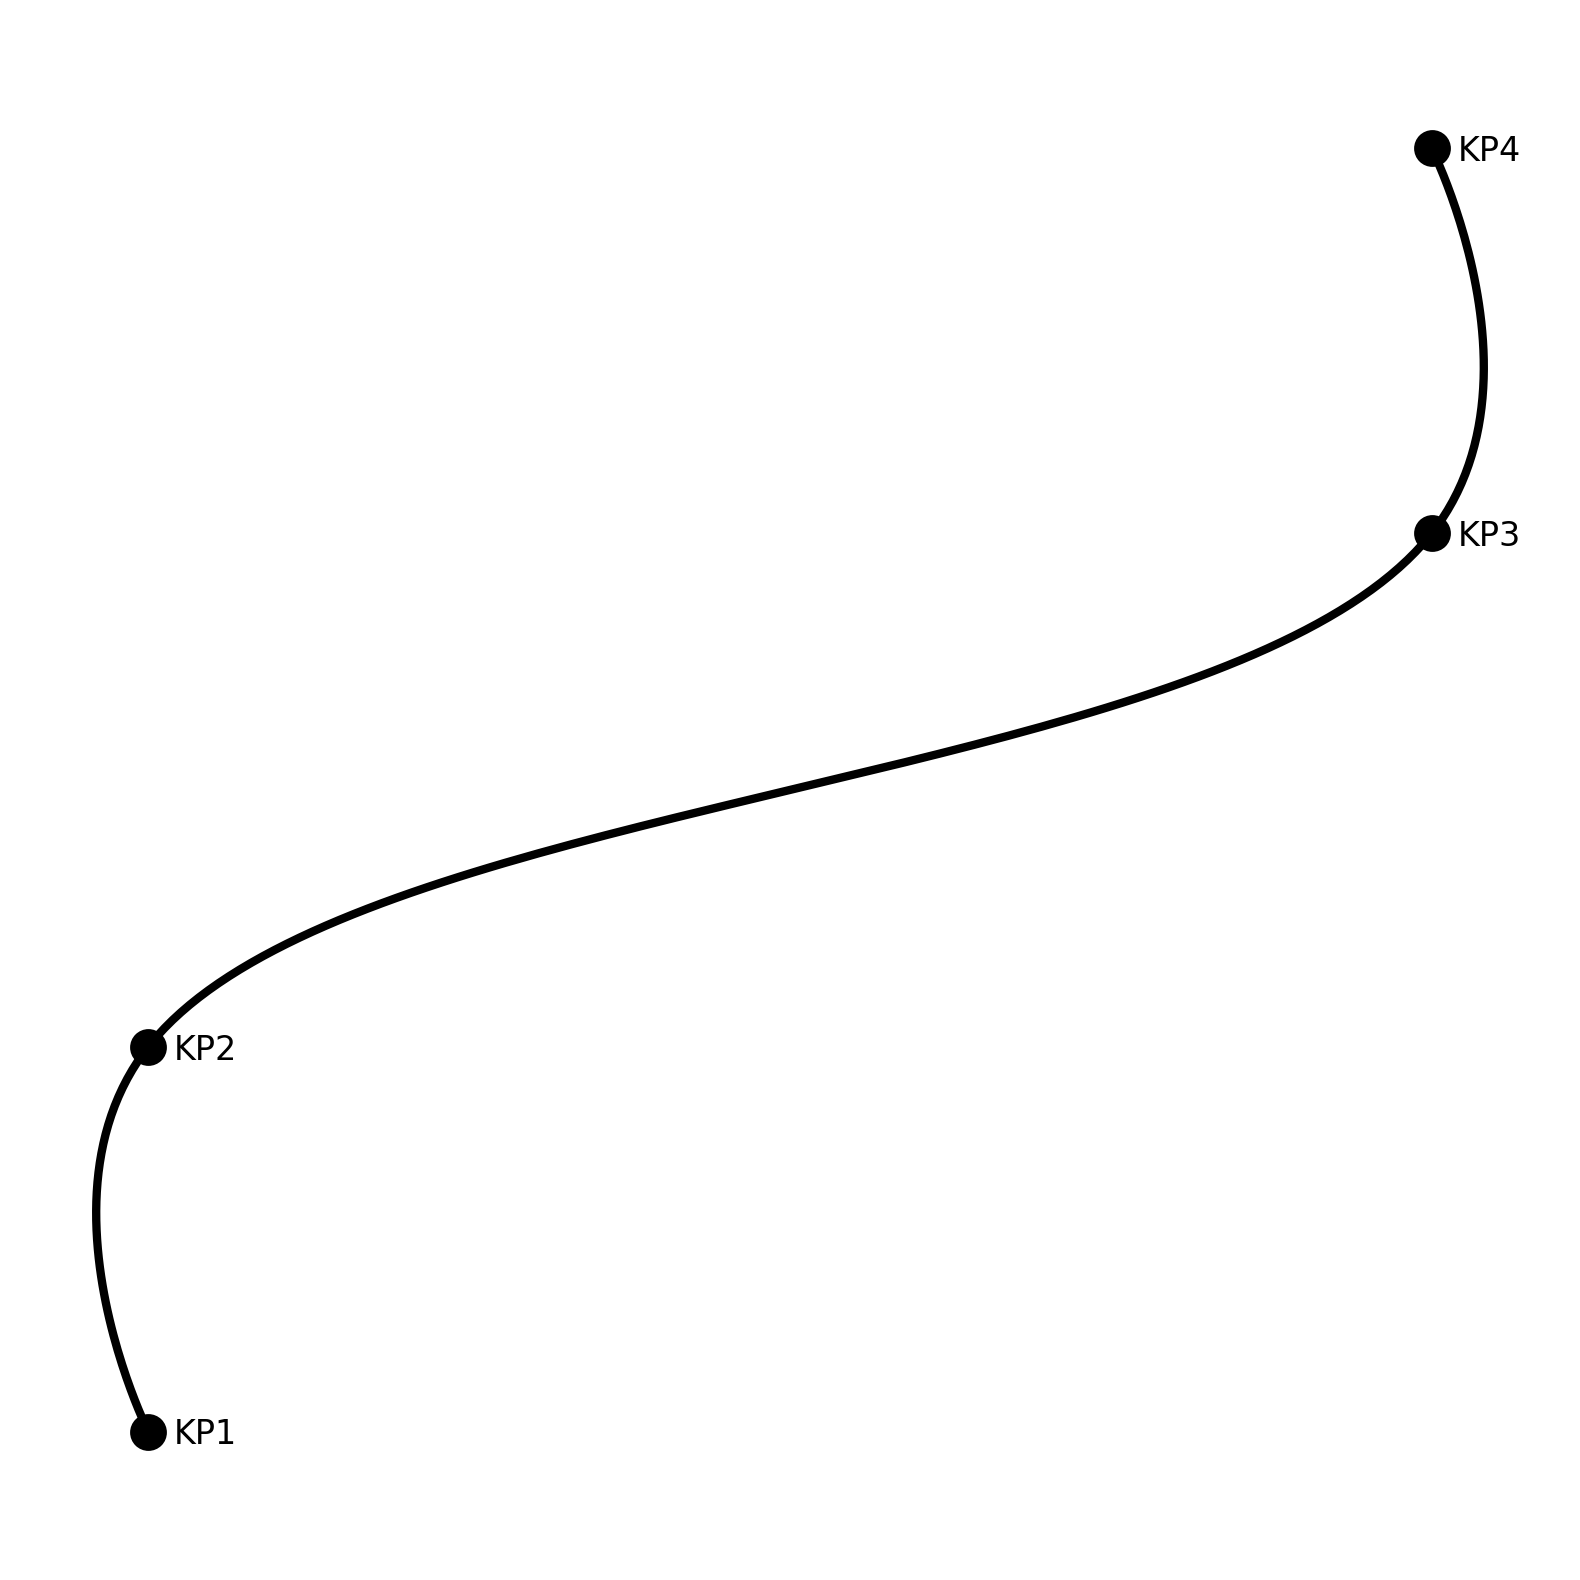

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=200, facecolor='w', edgecolor='k')

plt.scatter(y_nodes[:,0], y_nodes[:,1], s=150, c="k")

plot, = ax.plot([], [], "k", lw=lw_)

for i in range(len(y_nodes)):
    ax.text(y_nodes[i,0]+0.02, y_nodes[i,1]-0.01, r'KP'+str(i+1), fontsize=12)

axes = plt.gca()
axes.set_xlim([-0.1,1.1])
axes.set_ylim([-0.1,1.1])

plt.xticks([])
plt.yticks([])
plt.grid()
plt.box()

plt.tight_layout()

def animate(i):
    i_ = int(np.floor(i/fps))
    j = i/fps - i_
    if i_ >= iteration-1:
        h_opt = h_list[-1]
    else:
        h_opt = h_list[i_] + j * (h_list[i_+1] - h_list[i_])
    T = np.sum(h_opt)
    t = np.linspace(0,T,int(res))
    to.setup_task(h_opt)
    y = to.get_y(t, y_nodes, dy_0, dy_T)
    plot.set_xdata(y[:,0])
    plot.set_ydata(y[:,1])
    return plot, 

ani = animation.FuncAnimation(
fig, animate, interval=1e3/fps, blit=True, frames=(iteration-1)*fps, repeat=False)

video_name = r"/home/julius/Documents/" + filename + "_pos.mp4" 
writervideo = animation.FFMpegWriter(fps=fps)
ani.save(video_name, writer=writervideo)

Animate Velocity

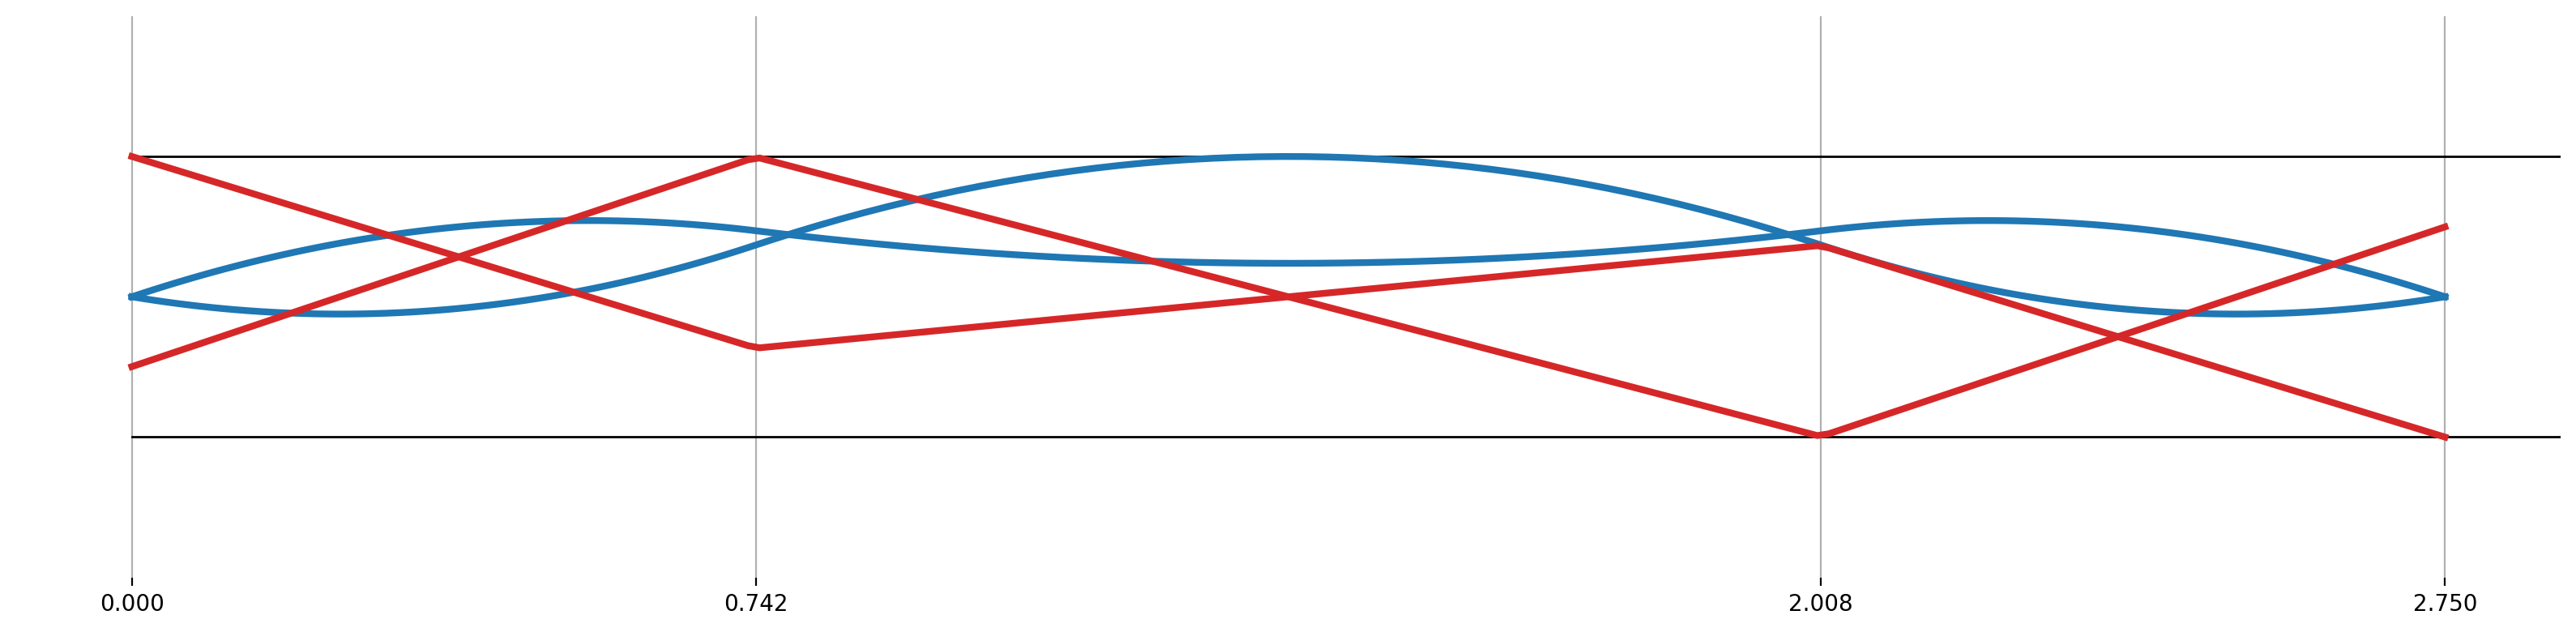

In [11]:
fig, ax = plt.subplots(figsize=(fw_, fh_), dpi=200, facecolor='w', edgecolor='k')

plt.plot([0,10.0], [1, 1], 'k', lw=1)
plt.plot([0,10.0], [-1, -1], 'k', lw=1)

plot_1, = ax.plot([], [], color=blue, lw=lw_)
plot_2, = ax.plot([], [], color=blue, lw=lw_)

plot_3, = ax.plot([], [], color=red, lw=lw_)
plot_4, = ax.plot([], [], color=red, lw=lw_)

axes = plt.gca()
axes.set_ylim([-1.0-1.0,1.0+1.0])

#plt.xticks([])
plt.yticks([])
plt.grid()
plt.box()

plt.tight_layout()

def animate(i):
    i_ = int(np.floor(i/fps))
    j = i/fps - i_
    if i_ >= iteration-1:
        h_opt = h_list[i_]
    else:
        h_opt = h_list[i_] + j * (h_list[i_+1] - h_list[i_])
    T = np.sum(h_opt)
    t = np.linspace(0,T,int(res))
    to.setup_task(h_opt)
    
    dy = to.get_dy(t, y_nodes, dy_0, dy_T)/dy_lim
    plot_1.set_xdata(t)
    plot_1.set_ydata(dy[:,0])
    plot_2.set_xdata(t)
    plot_2.set_ydata(dy[:,1])

    ddy = to.get_ddy(t, y_nodes, dy_0, dy_T)/ddy_lim
    plot_3.set_xdata(t)
    plot_3.set_ydata(ddy[:,0])
    plot_4.set_xdata(t)
    plot_4.set_ydata(ddy[:,1])

    axes.set_xlim([-0.05*T,T+T*0.05])

    t_via = np.zeros(N+1)
    for n in range(N):
        t_via[n+1] = t_via[n] + h_opt[n]
    plt.xticks(t_via)

    return plot, 

ani = animation.FuncAnimation(
fig, animate, interval=1e3/fps, blit=True, frames=(iteration-1)*fps, repeat=False)

video_name = r"/home/julius/Documents/" + filename + "_dyn.mp4" 
writervideo = animation.FFMpegWriter(fps=fps)
ani.save(video_name, writer=writervideo)

Animate acceleration

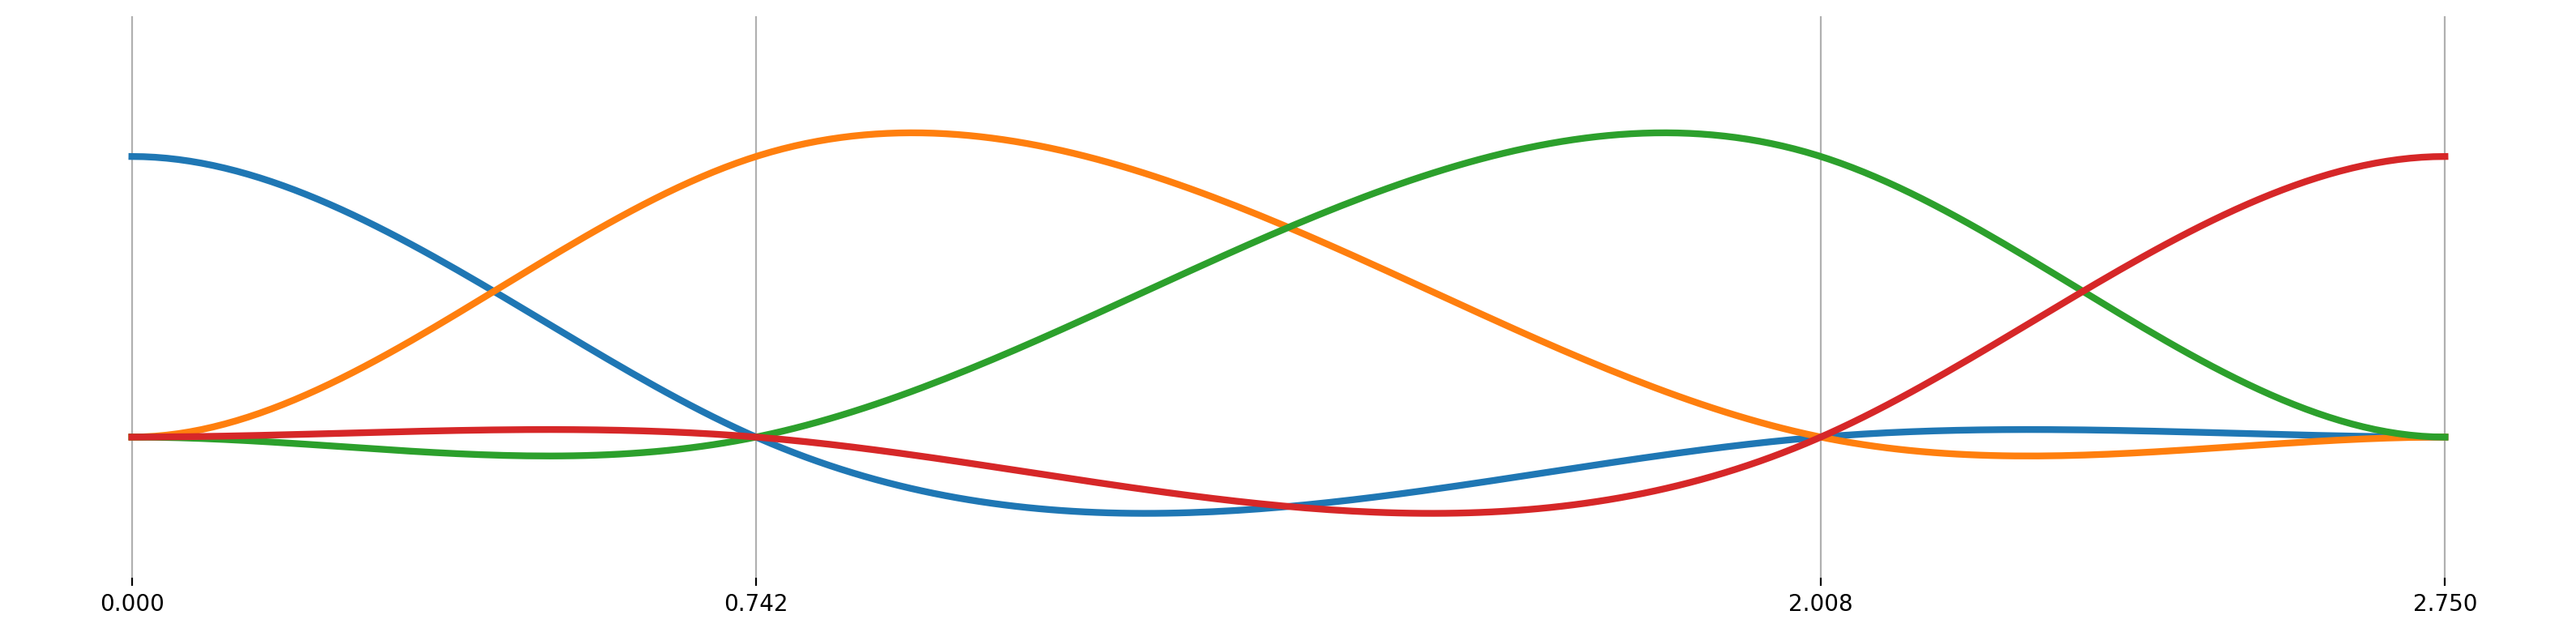

In [12]:
to_basis = TrajOpt(1)

fig, ax = plt.subplots(figsize=(fw_, fh_), dpi=200, facecolor='w', edgecolor='k')

plots = []
for i in range(N+1):
    plots.append(ax.plot([], [], lw=lw_))

#plt.xticks([])
plt.yticks([])
plt.grid()
plt.box()
axes = plt.gca()

plt.tight_layout()

def animate(i):
    i_ = int(np.floor(i/fps))
    j = i/fps - i_
    if i_ >= iteration-1:
        h_opt = h_list[-1]
    else:
        h_opt = h_list[i_] + j * (h_list[i_+1] - h_list[i_])
    T = np.sum(h_opt)
    t = np.linspace(0,T,res)
    to_basis.setup_task(h_opt)
    phi_obf = to_basis.get_Phi(t)[:,:-2]
    for j in range(len(plots)):
        plots[j][0].set_xdata(t)
        plots[j][0].set_ydata(phi_obf[:,j])
    
    axes.set_xlim([-0.05*T,T+T*0.05])
    axes.set_ylim([-0.5,1.5])

    t_via = np.zeros(N+1)
    for n in range(N):
        t_via[n+1] = t_via[n] + h_opt[n]
    plt.xticks(t_via)

    return plots[0][0],

ani = animation.FuncAnimation(
fig, animate, interval=1e3/fps, blit=True, frames=(iteration-1)*fps, repeat=False)

video_name = r"/home/julius/Documents/" + filename + "_basis.mp4" 
writervideo = animation.FFMpegWriter(fps=fps)
ani.save(video_name, writer=writervideo)

Animate Timing

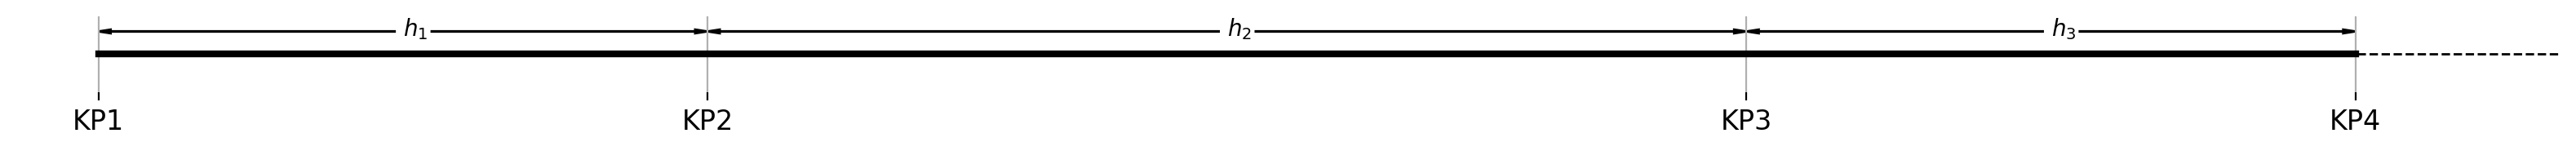

In [13]:
def get_arrows(t_1, t_2):
    x = (t_1 + t_2)/2
    y = 0.05+0.01
    dt = (t_2 - t_1)/2
    arrow_1 = mpatches.FancyArrow(x+0.035, y, dt-0.035, 0.0, width=.001, length_includes_head=True, head_width=0.01, color="k")
    arrow_2 = mpatches.FancyArrow(x-0.01, y, -dt+0.01, 0.0, width=.001, length_includes_head=True, head_width=0.01, color="k")
    return arrow_1, arrow_2

fig, ax = plt.subplots(figsize=(fw_, 1), dpi=200, facecolor='w', edgecolor='k')

plt.plot([0, 3.0], [0, 0], 'k--', lw=1)

plot, = ax.plot([], [], 'k', lw=lw_)

text_plots = []
arrows = []
for i in range(N):
    text_plots.append(ax.text(1.5, 0.05, r'$h_'+str(i+1)+'$'))
    arrows.append(get_arrows(0,3))
    ax.add_patch(arrows[-1][0])
    ax.add_patch(arrows[-1][1])

axes = plt.gca()
axes.set_xlim([-0.1,3.0])
axes.set_ylim([-0.1,0.1])

#plt.xticks([])
plt.yticks([])
plt.grid()
plt.box()

#plt.subplots_adjust(bottom=0.3)
plt.tight_layout()

t_labels = ['KP1', 'KP2', 'KP3', 'KP4']

def animate(i):
    i_ = int(np.floor(i/fps))
    j = i/fps - i_
    if i_ >= iteration-1:
        h_opt = h_list[-1]
        print(i_, j)
    else:
        h_opt = h_list[i_] + j * (h_list[i_+1] - h_list[i_])
    T = np.sum(h_opt)
    
    plot.set_xdata([0, T])
    plot.set_ydata([0, 0])

    t_via = np.zeros(N+1)
    for n in range(N):
        t_via[n+1] = t_via[n] + h_opt[n]
        text_plots[n].set_position((0.5*(t_via[n]+t_via[n+1]), 0.05))
        ax.patches.remove(arrows[n][0])
        ax.patches.remove(arrows[n][1])
        arrows[n] = get_arrows(t_via[n], t_via[n+1])
        ax.add_patch(arrows[n][0])
        ax.add_patch(arrows[n][1])
    plt.xticks(t_via, t_labels, fontsize=12)

    return plot, 

ani = animation.FuncAnimation(
fig, animate, interval=1e3/fps, blit=True, frames=(iteration-1)*fps, repeat=False)

video_name = r"/home/julius/Documents/" + filename + "_time.mp4" 
writervideo = animation.FFMpegWriter(fps=fps)
ani.save(video_name, writer=writervideo)

In [14]:
h = get_optimal_h(iteration)
T = np.sum(h)
t = np.linspace(0,T,int(1000*T))

to.setup_task(h)

y = to.get_y(t, y_nodes, dy_0, dy_T)
dy = to.get_dy(t, y_nodes, dy_0, dy_T)
ddy = to.get_ddy(t, y_nodes, dy_0, dy_T)

[0.1 0.1 0.1]
[0.1462236 0.1522137 0.1462236]
[0.21194111 0.23357947 0.21194111]
[0.30292525 0.36410309 0.30292525]
[0.42086469 0.58666504 0.42086474]
[0.59738086 0.9027983  0.60035155]
[0.70084827 1.15929095 0.76562351]
[0.73489704 1.25135215 0.82113822]
[0.73779173 1.25956768 0.81974442]
[0.73950705 1.26229663 0.78580559]
[0.74224934 1.26730228 0.73848677]
[0.74218466 1.26605885 0.74215813]
[0.74218406 1.26605247 0.74218406]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27504205892739136
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13


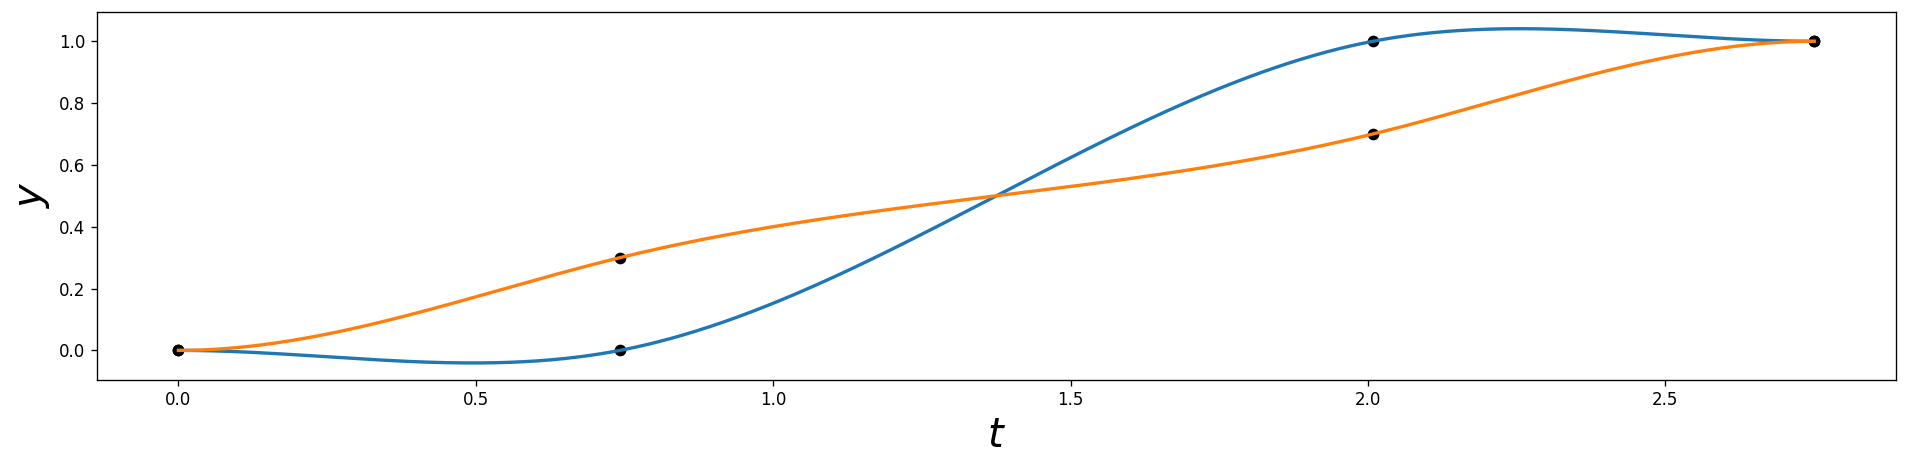

In [15]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$y$', fontsize=fontsize_)

plt.plot(t, y, lw=lw_)

for n in range(N+1):
    plt.scatter(np.sum(h[:n])*np.ones(ndof), y_nodes[n], color='k')
    
plt.tight_layout()
#plt.savefig("time_optimal_y.png")

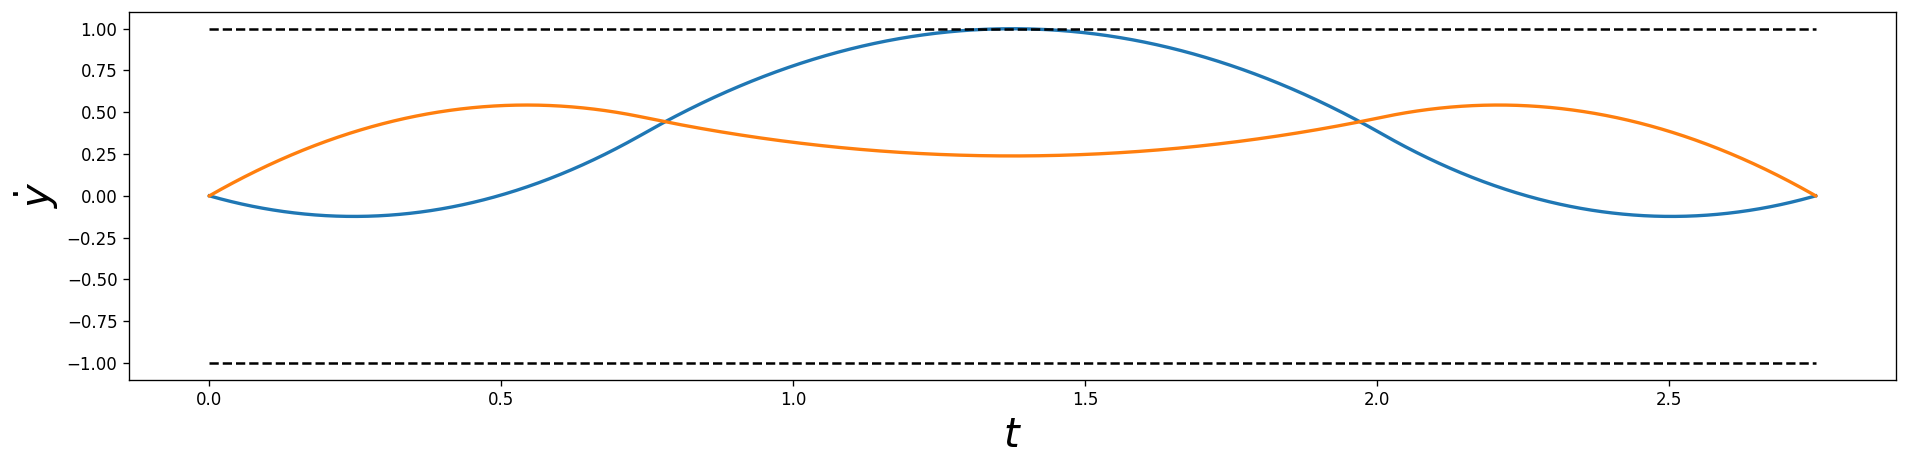

In [16]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\dot{y}$', fontsize=fontsize_)

plt.plot(t, dy, lw=lw_)

plt.plot([0,T], [dy_lim, dy_lim], 'k--')
plt.plot([0,T], [-dy_lim, -dy_lim], 'k--')

plt.tight_layout()
#plt.savefig("time_optimal_dy.png")

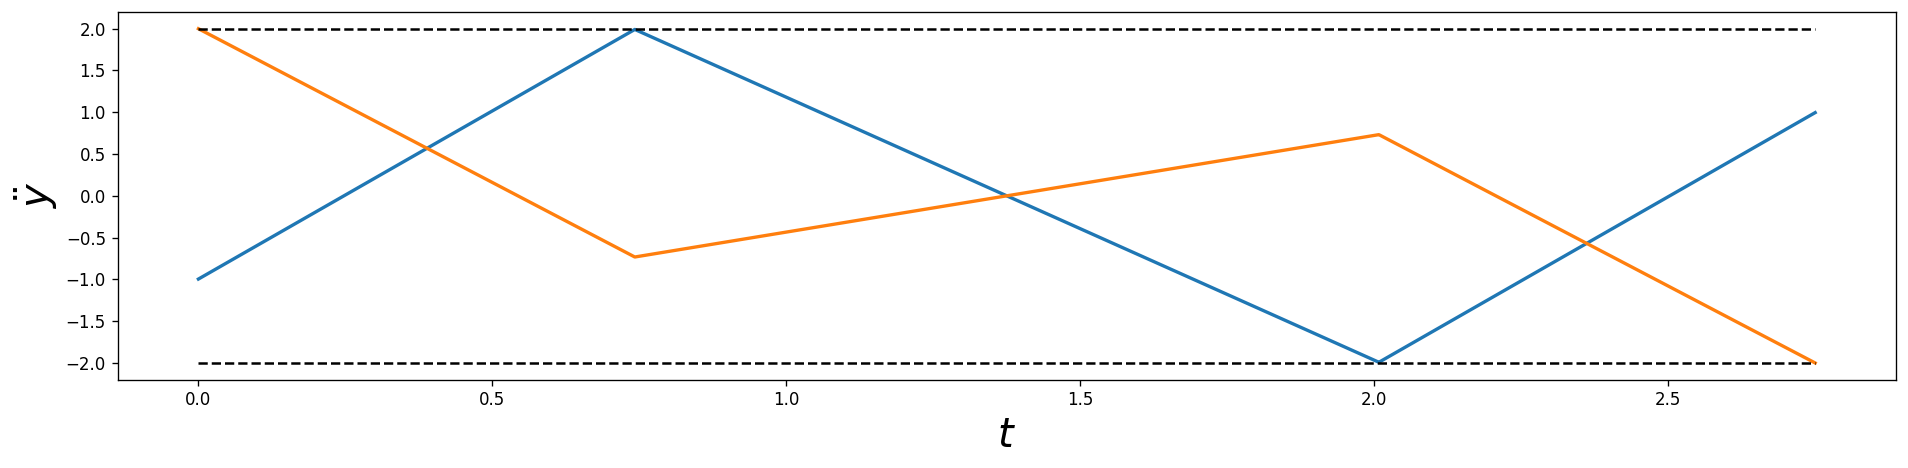

In [17]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\ddot{y}$', fontsize=fontsize_)

plt.plot(t, ddy, lw=lw_)

plt.plot([0,T], [ddy_lim, ddy_lim], 'k--')
plt.plot([0,T], [-ddy_lim, -ddy_lim], 'k--')

plt.tight_layout()
#plt.savefig("time_optimal_ddy.png")

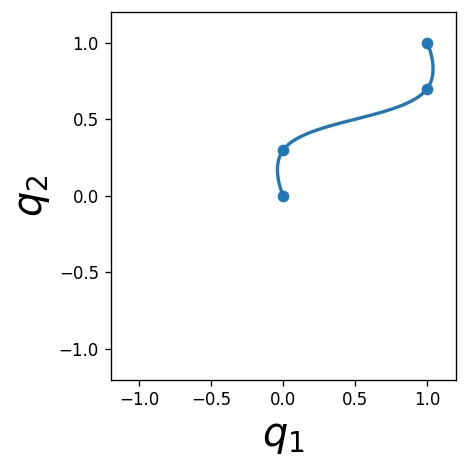

In [18]:
plt.figure(figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])

lw_ = 2
fontsize_ = 24

plt.scatter(y_nodes[:,0], y_nodes[:,1])

plt.plot(y[:,0], y[:,1], lw=lw_)

plt.xlabel(r'$q_1$', fontsize=fontsize_)
plt.ylabel(r'$q_2$', fontsize=fontsize_)

plt.tight_layout()